In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Recurrent Neural Networks

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

34731

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 28 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 13,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 14,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 15,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 16,
 'DIREZIONE GENERALE BILANCIO 

In [4]:
filtered_labels = {k:v for k,v in label_index_dict.items() if 'DIREZIONE' in k}
filtered_labels

reverse_filtered_labels = {v:k for k,v in filtered_labels.items()}

In [5]:
filtered_labels

{'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 13,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 14,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 15,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 16,
 'DIREZIONE GENERALE BILANCIO E FINANZE                 ': 17,
 'DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI ': 18,
 'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT': 19,
 "DIREZIONE GENERALE POLITICHE MOBILITA', INFRASTRUTTURE E TRASPORTO PUBBLICO LOCALE": 20,
 'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI': 21,
 'DIREZIONE GENERALE SVILUPPO ECONOMICO                 ': 22,
 'DIREZIONE ISTRUZIONE E FORMAZIONE': 23,
 'DIREZIONE LAVORO': 24,
 'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI': 25}

In [6]:
mapping_dict = dict(enumerate(filtered_labels.values()))
reverse_mapping_dict = {v:k for k,v in mapping_dict.items()}

In [7]:
to_keep = []
for i in range(len(y_train)):
    if y_train[i] in reverse_filtered_labels:
        to_keep.append(i)

In [8]:
x_train_filtered = x_train[to_keep]
y_train_filtered = y_train[to_keep]

In [9]:
filtered_label_index_dict = {k: reverse_mapping_dict[v] for k,v in filtered_labels.items()}

In [10]:
filtered_label_index_dict

{'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 0,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 1,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 2,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 3,
 'DIREZIONE GENERALE BILANCIO E FINANZE                 ': 4,
 'DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI ': 5,
 'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT': 6,
 "DIREZIONE GENERALE POLITICHE MOBILITA', INFRASTRUTTURE E TRASPORTO PUBBLICO LOCALE": 7,
 'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI': 8,
 'DIREZIONE GENERALE SVILUPPO ECONOMICO                 ': 9,
 'DIREZIONE ISTRUZIONE E FORMAZIONE': 10,
 'DIREZIONE LAVORO': 11,
 'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI': 12}

In [11]:
y_train_mapped = [reverse_mapping_dict[x] for x in y_train_filtered]
y_train_mapped = np.array(y_train_mapped)

In [12]:
to_keep_test = []
for i in range(len(y_test)):
    if y_test[i] in reverse_filtered_labels:
        to_keep_test.append(i)

In [13]:
x_test_filtered = x_test[to_keep_test]
y_test_filtered = y_test[to_keep_test]

In [14]:
y_test_mapped = [reverse_mapping_dict[x] for x in y_test_filtered]
y_test_mapped = np.array(y_test_mapped)

In [15]:
y_test_mapped

array([ 2,  2, 12, ...,  3, 12,  3])

## Data Preparation

We need to create the function that transform the x and y.
In this case we need to:
- x: pad the sequences
- y: one hot encoding

In [16]:
maxlen = max([len(x) for x in x_train_filtered])
maxlen

156

In [17]:
from functools import partial

def x_transformer(x_data):
    return partial(tf.keras.preprocessing.sequence.pad_sequences, x_data, maxlen, padding='post')

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [18]:
batch_size = 64
num_classes = len(reverse_mapping_dict)
train_val_split = math.ceil(len(x_train_filtered) * 0.7)
print('num classes {}'.format(len(mapping_dict)))
print('training size {}, validation size {}'.format(train_val_split, len(x_train_filtered) - train_val_split))

num classes 13
training size 49049, validation size 21021


In [19]:
train_generator = dataset_utils.dataset_generator_fun(x_train_filtered, y_train_mapped, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train_filtered, y_train_mapped, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train_filtered), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train_filtered) - train_val_split) // batch_size + 1

## Models

We evaluate: 
- CNN
- LSTM and GRU models with dropout, 
- reverse the text order and uses Bidirectional-LSTM 

### CNN

In [20]:
def build_model_cnn(num_words, num_classes, embed_size, dropout=0.2):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Conv1D(64,3, activation='relu')(embed_l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.MaxPooling1D(2)(l)
    l = tf.keras.layers.Conv1D(128,3, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.MaxPooling1D(2)(l)
    l = tf.keras.layers.Conv1D(256,3, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.GlobalMaxPool1D()(l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)    
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)    
    l = tf.keras.layers.Dense(32, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [24]:
cnn_model = build_model_cnn(num_words, num_classes, 100, dropout=0.3)
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 156)               0         
_________________________________________________________________
embed (Embedding)            (None, 156, 100)          3473100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 154, 64)           19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 154, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 77, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 128)           0         
__________

In [25]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('cnn_filtered', '64_128_256_128_64')),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
    ]  

In [27]:
cnn_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=15, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/15
767/767 [==============================] - 11s 14ms/step - loss: 1.9466 - acc: 0.3234 - val_loss: 1.6784 - val_acc: 0.4771
Epoch 2/15
767/767 [==============================] - 11s 14ms/step - loss: 1.4695 - acc: 0.5019 - val_loss: 1.3190 - val_acc: 0.5836
Epoch 3/15
767/767 [==============================] - 11s 14ms/step - loss: 1.1879 - acc: 0.5972 - val_loss: 1.0110 - val_acc: 0.6797
Epoch 4/15
767/767 [==============================] - 11s 14ms/step - loss: 1.0132 - acc: 0.6538 - val_loss: 0.8999 - val_acc: 0.7162
Epoch 5/15
767/767 [==============================] - 11s 14ms/step - loss: 0.8863 - acc: 0.7024 - val_loss: 0.7788 - val_acc: 0.7427
Epoch 6/15
767/767 [==============================] - 11s 14ms/step - loss: 0.7867 - acc: 0.7368 - val_loss: 0.7211 - val_acc: 0.7754
Epoch 7/15
767/767 [==============================] - 11s 14ms/step - loss: 0.7210 - acc: 0.7583 - val_loss: 0.6476 - val_acc: 0.7933
Epoch 8/15
767/767 [==============================] - 11s 15ms

### LSTM

In [40]:
def build_model_rnn(neurons, num_words, num_class, embed_size, dropout, rec_dropout, cell=tf.keras.layers.GRU):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Bidirectional(
        cell(neurons, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=True)
    )(embed_l)
    l = tf.keras.layers.GRU(64, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=False)(l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(256, activation='relu')(l)
    l = tf.keras.layers.Dropout(0.3)(l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model 

In [41]:
neurons = 64

gru_model = build_model_rnn(neurons, num_words, num_classes, 100, 0.3, 0.3)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('gru_filtered', neurons)),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
    ] 

gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 156)               0         
_________________________________________________________________
embed (Embedding)            (None, 156, 100)          3473100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 156, 128)          63360     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [42]:
import gc
gc.collect()

522

In [ ]:
history = gru_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=15, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/15
767/767 [==============================] - 439s 572ms/step - loss: 2.3807 - acc: 0.1512 - val_loss: 2.1750 - val_acc: 0.2771
Epoch 2/15
767/767 [==============================] - 435s 567ms/step - loss: 1.7163 - acc: 0.4248 - val_loss: 1.1034 - val_acc: 0.6434
Epoch 3/15
767/767 [==============================] - 434s 566ms/step - loss: 1.0851 - acc: 0.6437 - val_loss: 0.7859 - val_acc: 0.7376
Epoch 4/15
767/767 [==============================] - 435s 567ms/step - loss: 0.8140 - acc: 0.7326 - val_loss: 0.6144 - val_acc: 0.7966
Epoch 5/15
767/767 [==============================] - 435s 568ms/step - loss: 0.6645 - acc: 0.7815 - val_loss: 0.5339 - val_acc: 0.8219
Epoch 6/15
767/767 [==============================] - 443s 577ms/step - loss: 0.5528 - acc: 0.8172 - val_loss: 0.4826 - val_acc: 0.8400
Epoch 7/15
767/767 [==============================] - 445s 580ms/step - loss: 0.4752 - acc: 0.8432 - val_loss: 0.4377 - val_acc: 0.8541
Epoch 8/15
767/767 [============================

In [ ]:
import gc
gc.collect()

In [ ]:
lstm_model = build_model_rnn(64, num_words, num_classes, 100, 0.3, 0.3, cell=tf.keras.layers.LSTM)
lstm_model.summary()

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('lstm_filtered', '64')),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
    ]  

In [ ]:
history = lstm_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=20, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

We can see the there is no improvement in using an embedding layer, but we have milion of parameters with respect to thousand of observations. 

## Build the final model

the best model is obtained embedding of size 64

In [ ]:
import gc
gc.collect()

In [ ]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [ ]:
model = build_model_cnn(num_words, num_classes, embed_size)
cnn_model.summary()

In [ ]:
history = model.fit_generator(train_generator, train_steps, 8)

## Evaluate on the test set

In [29]:
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_filtered, maxlen)

In [30]:
x_test_v = dataset_utils.vectorize_sequences(x_test_filtered, num_words)
y_test_v = dataset_utils.to_one_hot(y_test_mapped, num_classes)

In [31]:
test_predictions = cnn_model.predict(x_test_pad, verbose=1)

17518/17518 [==============================] - 1s 55us/step


In [32]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test_mapped,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test_mapped, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.7729192830231761
precision  0.7965324670281343
recall  0.7729192830231761
f-measure  0.7740253030864677


### Report the classification result for each class

In [33]:
print(metrics.classification_report(y_test_mapped, predictions))

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      2718
          1       0.90      0.63      0.74       370
          2       1.00      0.76      0.87      1142
          3       0.87      0.52      0.65      1890
          4       0.58      0.58      0.58       525
          5       0.62      0.73      0.67      1496
          6       0.56      0.84      0.67      1204
          7       0.37      0.27      0.32       333
          8       0.75      0.82      0.78      2364
          9       0.85      0.83      0.84      1945
         10       0.97      0.81      0.88       931
         11       0.66      0.90      0.77       282
         12       0.69      0.83      0.75      2318

avg / total       0.80      0.77      0.77     17518



### Confusion Matrix

In [34]:
conf_matrix = metrics.confusion_matrix(y_test_filtered, predictions)

In [39]:
conf_matrix

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  

In [37]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


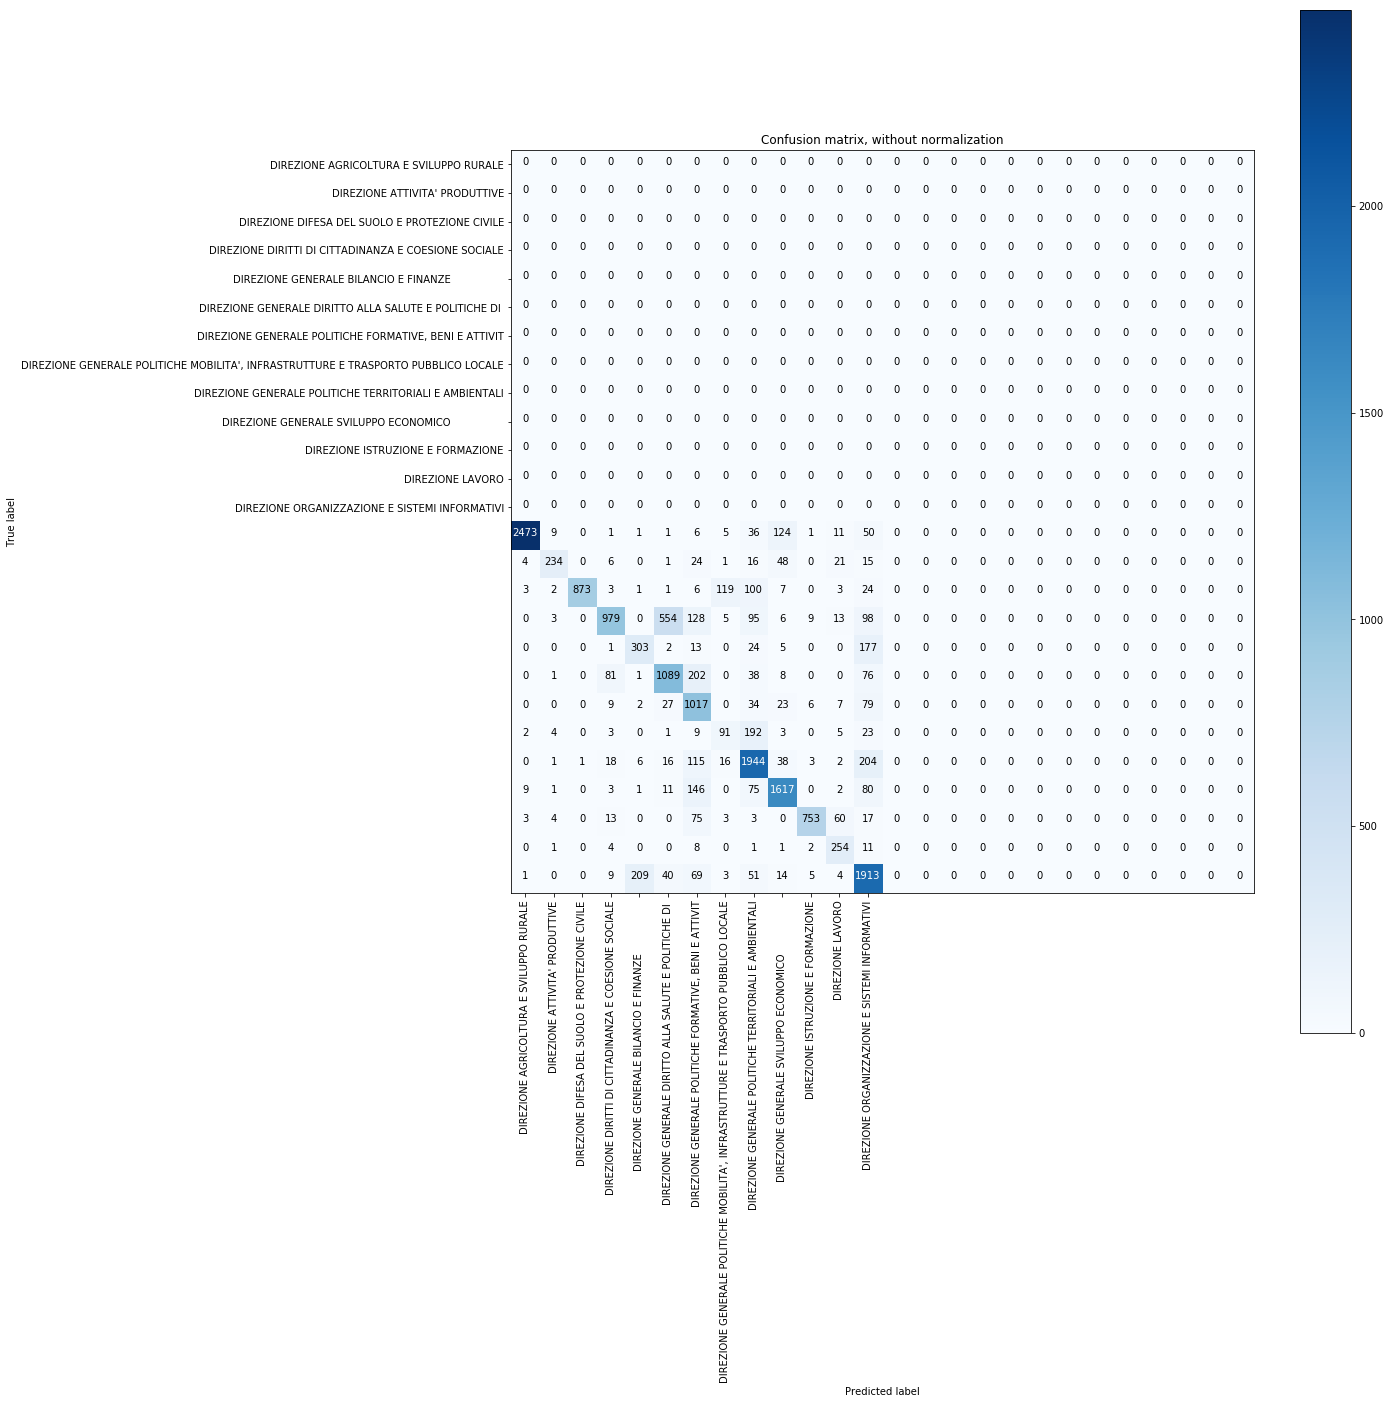

In [38]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=filtered_label_index_dict,
                      title='Confusion matrix, without normalization')